This is the notebook for the challenge. It takes more or less 15min to run. More info can be found in the README

In [1]:
import random
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
import torch
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import ToUndirected
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

# set state reproducibility
rand_state = 7

---
# Initial data exploration
---

* `Edges.csv`: Contains relationships between nodes in the knowledge graph
* `Embeddings.csv`: Node embeddings for drugs, diseases, and other entities (precomputed)
* `Ground Truth.csv`: True positive and negative drug-disease pairs for training and testing the classifier
* `Nodes.csv`: Metadata or details about the nodes in the graph

In [2]:
PATH2DATA = Path("./data/")
assert PATH2DATA.is_dir()

In [3]:
# Load the datasets
edges_df = pd.read_csv(PATH2DATA.joinpath("Edges.csv"), index_col=0)
nodes_df = pd.read_csv(PATH2DATA.joinpath("Nodes.csv"), index_col=0)
ground_truth_df = pd.read_csv(PATH2DATA.joinpath("Ground Truth.csv"), index_col=0)
embeddings_df = pd.read_csv(PATH2DATA.joinpath("Embeddings.csv"), index_col=0)

# Display col data structure - initial feel & exploration
print("Edges col: ", edges_df.columns)
print(edges_df.shape)
print("Nodes col: ", nodes_df.columns)
print(nodes_df.shape)
print("Ground Truth col: ", ground_truth_df.columns)
print("Embeddings col: ", embeddings_df.columns)

Edges col:  Index(['subject', 'object', 'predicate', 'knowledge_source', 'publications',
       'publications_info', 'type', 'start_id', 'end_id'],
      dtype='object')
(183760, 9)
Nodes col:  Index(['id', 'name', 'category', 'all_names', 'all_categories', 'iri',
       'description', 'equivalent_curies', 'publications', 'label'],
      dtype='object')
(170009, 10)
Ground Truth col:  Index(['source', 'target', 'y'], dtype='object')
Embeddings col:  Index(['id', 'name', 'category', 'all_names', 'all_categories', 'iri',
       'description', 'equivalent_curies', 'publications', 'label',
       'topological_embedding'],
      dtype='object')


In [4]:
# Display data
edges_df.head(3)

,subject,object,predicate,knowledge_source,publications,publications_info,type,start_id,end_id
0,NCBIGene:8483,FMA:70022,biolink:related_to,infores:ensembl-gene,NaN,{},biolink:related_to,NCBIGene:8483,FMA:70022
1,NCBIGene:390650,CHEMBL.TARGET:CHEMBL372,biolink:in_taxon,infores:ncbi-geneǂinfores:ensembl-gene,NaN,{},biolink:in_taxon,NCBIGene:390650,CHEMBL.TARGET:CHEMBL372
2,UMLS:C1158823,ENSEMBL:ENST00000485267,biolink:has_participant,infores:ensembl-gene,NaN,{},biolink:has_participant,UMLS:C1158823,ENSEMBL:ENST00000485267


In [5]:
# Check unique relationship types
print("Edge types:", edges_df["predicate"].unique())

Edge types: ['biolink:related_to' 'biolink:in_taxon' 'biolink:has_participant'
 'biolink:transcribed_from' 'biolink:translates_to' 'biolink:subclass_of'
 'biolink:overlaps' 'biolink:has_part' 'biolink:physically_interacts_with'
 'biolink:entity_negatively_regulates_entity'
 'biolink:increases_activity_of' 'biolink:decreases_activity_of'
 'biolink:entity_regulates_entity' 'biolink:treats'
 'biolink:has_metabolite' 'biolink:affects'
 'biolink:molecularly_interacts_with'
 'biolink:entity_positively_regulates_entity'
 'biolink:directly_interacts_with' 'biolink:affects_activity_of'
 'biolink:occurs_in' 'biolink:has_input' 'biolink:has_output'
 'biolink:same_as' 'biolink:gene_product_of' 'biolink:derives_from'
 'biolink:close_match' 'biolink:located_in' 'biolink:actively_involved_in'
 'biolink:enables' 'biolink:lacks_part' 'biolink:coexists_with'
 'biolink:causes' 'biolink:produces' 'biolink:precedes'
 'biolink:capable_of' 'biolink:gene_associated_with_condition'
 'biolink:biomarker_for' 'bi

In `edges_df` we have:

* `subject`: The source node of the edge (e.g., a drug or gene)
* `object`: The target node of the edge (e.g., a disease or gene)
* `predicate`: The type of relationship (e.g., `biolink:related_to`, `biolink:in_taxon`)
* Other metadata columns like `knowledge_source`, `publications`, and etc...

Based on unique values in `predicate`, the most relevant values for drug-disease relationships are: 
* `biolink:treats`: Represents a "drug-treats-disease" relationship
* `biolink:contraindicated_for`: Indicates contraindications
* `biolink:prevents`: Suggests a preventive relationship, where a drug might prevent a disease
* Potentially, `biolink:biomarker_for`: Could imply indirect associations between drugs and diseases via biomarkers, but upon inspection doesn't seem to be drugs..

but how can I be sure I have assumed all the *valid* relationship links?

In [6]:
nodes_df.head(3)

,id,name,category,all_names,all_categories,iri,description,equivalent_curies,publications,label
0,UniProtKB:P53805,RCAN1,biolink:Protein,RCAN1 GeneǂGenetic locus associated with RCAN1...,biolink:NucleicAcidEntityǂbiolink:Geneǂbiolink...,https://identifiers.org/uniprot:P53805,"Calcipressin-1 (252 aa, ~28 kDa) is encoded by...",HGNC:3040ǂRGD:631338ǂNCIT:C82947ǂENSEMBL:ENSG0...,DOI:10.1042/bj20030267ǂPMID:12809556ǂDOI:10.10...,biolink:NucleicAcidEntityǂbiolink:MolecularEnt...
1,UniProtKB:Q4KWH8,PLCH1,biolink:Protein,"1-phosphatidylinositol 4,5-bisphosphate phosph...",biolink:NucleicAcidEntityǂbiolink:Geneǂbiolink...,https://identifiers.org/uniprot:Q4KWH8,A protein that is a translation product of the...,NCBIGene:23007ǂMGI:2683547ǂPR:000012838ǂUMLS:C...,DOI:10.1042/bj20041677ǂDOI:10.1186/1471-2164-8...,biolink:NucleicAcidEntityǂbiolink:MolecularEnt...
2,UniProtKB:Q9UPU7,TBC1D2B,biolink:Protein,TBC1D2B (human)ǂGenetic locus associated with ...,biolink:NucleicAcidEntityǂbiolink:Geneǂbiolink...,https://identifiers.org/uniprot:Q9UPU7,A protein that is a translation product of the...,PR:Q9UPU7ǂENSEMBL:ENSG00000167202ǂMGI:1914266ǂ...,DOI:10.1126/scisignal.2000475ǂPMID:19690332ǂDO...,biolink:NucleicAcidEntityǂbiolink:MolecularEnt...


In [7]:
# check node types
print("Node types:", nodes_df.category.unique())

Node types: ['biolink:Protein' 'biolink:Gene' 'biolink:SmallMolecule'
 'biolink:Disease' 'biolink:NucleicAcidEntity'
 'biolink:GrossAnatomicalStructure' 'biolink:ChemicalEntity'
 'biolink:Drug' 'biolink:PhysiologicalProcess'
 'biolink:DiseaseOrPhenotypicFeature' 'biolink:AnatomicalEntity'
 'biolink:Food' 'biolink:MolecularActivity' 'biolink:OrganismTaxon'
 'biolink:MolecularEntity' 'biolink:PhenotypicFeature' 'biolink:Behavior'
 'biolink:Polypeptide' 'biolink:CellLine' 'biolink:Cell'
 'biolink:CellularComponent' 'biolink:BiologicalEntity'
 'biolink:GeneFamily' 'biolink:ChemicalMixture' 'biolink:RNAProduct'
 'biolink:BiologicalProcess' 'biolink:BiologicalProcessOrActivity'
 'biolink:Pathway' 'biolink:Transcript' 'biolink:Vitamin'
 'biolink:NoncodingRNAProduct' 'biolink:BehavioralFeature']


#### From the categories in `nodes_df`, the following may be the most relevant:

Drugs:
* `biolink:Drug`: Represents drugs 
* `biolink:SmallMolecule`: May also represent drugs in some cases?

Diseases:
* `biolink:Disease`: Represents diseases 
* `biolink:DiseaseOrPhenotypicFeature`: May include diseases or related conditions?
* `biolink:PhenotypicFeature`: May include diseases or related conditions?

#### Initial pre-processing of the edges and nodes to check everything is ok
* Are all the nodes in `edges_df` in `nodes_df`?
* Does `nodes_df` only include nodes that are referenced in `edges_df`?

In [8]:
nodes_edges = set(edges_df["subject"]).union(set(edges_df["object"]))
assert nodes_edges == set(
    nodes_df["id"]
), f"nodes in edges edges and nodes in nodes_df do not match: {nodes_edges} != {set(nodes_df['id'])}"

---
# 1. Create graph
---
Based on this initial exploration, the data include multiple types of entities (e.g., drugs, diseases, genes) and relationships (e.g., "drug-treats-disease," "gene-translates_to-protein"). Therefore, I choose a **heterogeneous graph** as it explicitly models these contextual differences.

In [9]:
nodes_df.head(3)

,id,name,category,all_names,all_categories,iri,description,equivalent_curies,publications,label
0,UniProtKB:P53805,RCAN1,biolink:Protein,RCAN1 GeneǂGenetic locus associated with RCAN1...,biolink:NucleicAcidEntityǂbiolink:Geneǂbiolink...,https://identifiers.org/uniprot:P53805,"Calcipressin-1 (252 aa, ~28 kDa) is encoded by...",HGNC:3040ǂRGD:631338ǂNCIT:C82947ǂENSEMBL:ENSG0...,DOI:10.1042/bj20030267ǂPMID:12809556ǂDOI:10.10...,biolink:NucleicAcidEntityǂbiolink:MolecularEnt...
1,UniProtKB:Q4KWH8,PLCH1,biolink:Protein,"1-phosphatidylinositol 4,5-bisphosphate phosph...",biolink:NucleicAcidEntityǂbiolink:Geneǂbiolink...,https://identifiers.org/uniprot:Q4KWH8,A protein that is a translation product of the...,NCBIGene:23007ǂMGI:2683547ǂPR:000012838ǂUMLS:C...,DOI:10.1042/bj20041677ǂDOI:10.1186/1471-2164-8...,biolink:NucleicAcidEntityǂbiolink:MolecularEnt...
2,UniProtKB:Q9UPU7,TBC1D2B,biolink:Protein,TBC1D2B (human)ǂGenetic locus associated with ...,biolink:NucleicAcidEntityǂbiolink:Geneǂbiolink...,https://identifiers.org/uniprot:Q9UPU7,A protein that is a translation product of the...,PR:Q9UPU7ǂENSEMBL:ENSG00000167202ǂMGI:1914266ǂ...,DOI:10.1126/scisignal.2000475ǂPMID:19690332ǂDO...,biolink:NucleicAcidEntityǂbiolink:MolecularEnt...


In [10]:
# create heterograph

# map each node id (str) to an index for each node type to create local id mappings for nodes
nodetype_to_id_mapping = {
    nodetype: {node_id: idx for idx, node_id in enumerate(group["id"])}
    for nodetype, group in nodes_df.groupby("category")
}

# create global mapping 'node to nodetype' by map each node id (str) to node type
id_to_nodetype = nodes_df.set_index("id")["category"].to_dict()

# init heterograph
hetero_data = HeteroData()

# add nodes grouped by nodetype
for nodetype in nodetype_to_id_mapping.keys():
    num_nodes = len(nodetype_to_id_mapping[nodetype])
    hetero_data[nodetype].num_nodes = num_nodes
    # mapping is same as mapping in dict I created
    hetero_data[nodetype].node_ids = torch.arange(num_nodes)

# init edge storage
# each key is an edge type tuple: (source_nodetype, edge_type, target_nodetype)
# each value is pair of lists: 1st list stores source node indices and 2nd list stores target node indices.
edge_indices = defaultdict(lambda: ([], []))
for _, row in edges_df.iterrows():
    source = row["subject"]
    target = row["object"]
    edge_type = row["predicate"]

    # get nodetype for source node and target node
    source_nodetype = id_to_nodetype[source]
    target_nodetype = id_to_nodetype[target]

    # get local ids for each node in each category
    source_local_id = nodetype_to_id_mapping[source_nodetype][source]
    target_local_id = nodetype_to_id_mapping[target_nodetype][target]

    edge_indices[(source_nodetype, edge_type, target_nodetype)][0].append(source_local_id)
    edge_indices[(source_nodetype, edge_type, target_nodetype)][1].append(target_local_id)

# add edges to the graph
for edge_type, (sources, targets) in edge_indices.items():
    hetero_data[edge_type].edge_index = torch.tensor([sources, targets], dtype=torch.long)

Our hetero_data now contains:
- nodes grouped by their nodetype
- edges grouped by their (source_nodetype, edge_type, target_nodetype)

I check some properties to make sure the graph was constructed correctly.

In [11]:
hetero_data.has_isolated_nodes()

False

In [12]:
hetero_data.is_directed()

True

In [13]:
print("Number of nodes :", hetero_data.num_nodes)
print("Number of edges :", hetero_data.num_edges)
# hetero_data.node_types

Number of nodes : 170009
Number of edges : 183760


In [14]:
%%time
hetero_data.validate()

CPU times: user 99.6 ms, sys: 3.87 ms, total: 103 ms
Wall time: 63.6 ms


True

#### Directed or undirected graph?
In these data, we have a mix of relationship types that are directed (treats, ..) and undirected (e.g. overlaps, related_to). For the sake of simplicity and to capture maximum information flow between nodes, I choose to transform to an undirected graph. However, the downside is that I lose the semantics of directional edges... - something to think about in *future steps*?

In [15]:
# Convert the graph to an undirected graph
undirected_hetero_data = ToUndirected()(hetero_data)
print("Number of nodes :", undirected_hetero_data.num_nodes)
print("Number of edges :", undirected_hetero_data.num_edges)

Number of nodes : 170009
Number of edges : 367252


The number of edges has doubled, which is expected.

In [16]:
undirected_hetero_data.is_directed()

False

## Work with pre-computed embeddings

In [17]:
embeddings_df.head(3)

,id,name,category,all_names,all_categories,iri,description,equivalent_curies,publications,label,topological_embedding
0,UniProtKB:P53805,RCAN1,biolink:Protein,RCAN1 GeneǂGenetic locus associated with RCAN1...,biolink:NucleicAcidEntityǂbiolink:Geneǂbiolink...,https://identifiers.org/uniprot:P53805,"Calcipressin-1 (252 aa, ~28 kDa) is encoded by...",HGNC:3040ǂRGD:631338ǂNCIT:C82947ǂENSEMBL:ENSG0...,DOI:10.1042/bj20030267ǂPMID:12809556ǂDOI:10.10...,biolink:NucleicAcidEntityǂbiolink:MolecularEnt...,[-0.09720507 -0.02366368 -0.01756126 -0.096430...
1,UniProtKB:Q4KWH8,PLCH1,biolink:Protein,"1-phosphatidylinositol 4,5-bisphosphate phosph...",biolink:NucleicAcidEntityǂbiolink:Geneǂbiolink...,https://identifiers.org/uniprot:Q4KWH8,A protein that is a translation product of the...,NCBIGene:23007ǂMGI:2683547ǂPR:000012838ǂUMLS:C...,DOI:10.1042/bj20041677ǂDOI:10.1186/1471-2164-8...,biolink:NucleicAcidEntityǂbiolink:MolecularEnt...,[ 0.05282909 0.16689758 0.17749593 0.028352...
2,UniProtKB:Q9UPU7,TBC1D2B,biolink:Protein,TBC1D2B (human)ǂGenetic locus associated with ...,biolink:NucleicAcidEntityǂbiolink:Geneǂbiolink...,https://identifiers.org/uniprot:Q9UPU7,A protein that is a translation product of the...,PR:Q9UPU7ǂENSEMBL:ENSG00000167202ǂMGI:1914266ǂ...,DOI:10.1126/scisignal.2000475ǂPMID:19690332ǂDO...,biolink:NucleicAcidEntityǂbiolink:MolecularEnt...,[-1.98048055e-02 3.08241490e-02 -1.16399840e-...


In [18]:
embeddings_df["topological_embedding"][0]

'[-0.09720507 -0.02366368 -0.01756126 -0.09643095  0.04937942  0.06188626\n -0.02199607  0.07389036 -0.15640208 -0.01835484  0.14166848 -0.10678021\n -0.01216231  0.07947011 -0.03612143  0.02637139  0.03522846  0.009582\n -0.00092936  0.08993009  0.0519274   0.01399449  0.08821951  0.0183919\n  0.05280334 -0.00295148 -0.06647169 -0.19971453  0.13915363 -0.14245994\n -0.07439503  0.1667266  -0.1421921  -0.15488857  0.00087389 -0.15422538\n -0.08414526 -0.12991254 -0.01001676 -0.09319881 -0.0942786   0.00866982\n -0.04049063 -0.01836587  0.04634616  0.12996881  0.11693358 -0.04371183\n -0.12564185 -0.18583447  0.0869606   0.03199255  0.12939955 -0.07526549\n -0.04485259 -0.21899481 -0.09142101  0.0876801  -0.09712336 -0.07027259\n -0.02523985  0.2187793  -0.03997595  0.04494499 -0.03040079 -0.12386096\n  0.14075029  0.14062774 -0.05827978 -0.03617474 -0.03188511 -0.05674523\n  0.03880956  0.12541075 -0.04664381  0.02159499 -0.03783251  0.10582332\n  0.00439113  0.08545046 -0.12270842 -0.

I need to parse this to be able to retrieve the embeddings for each node

In [19]:
# convert the 'embeddings' column to numpy arrays
embeddings_df["topological_embedding"] = embeddings_df["topological_embedding"].apply(
    lambda x: np.fromstring(x.replace("\n", "").replace("[", "").replace("]", ""), sep=" ")
)
# dict containing node_id and corresponding embedding
node_embeddings_dict = embeddings_df.set_index("id")["topological_embedding"].to_dict()

---
# 2. Train a classifier to predict drug-disease links using the generated embeddings
---

Here, we care about predicting drug-disease pair links. For simplicity and speed, I select a Random Forest Classifier. A Random Forest Classifier is faster to train for a moderate dataset and easy to implement.

Node embeddings are already precomputed, so I don’t need a graph-based approach to learn them dynamically--if I had generated the embeddings, I would have generated them by leveraging a GNN and then using those embeddings to perform the prediction taks.

### A. Prepare feature vectors for drug-disease pairs in the `Ground Truth.csv` dataset

Embeddings for individual nodes (drugs/diseases) must be transformed into a joint representation of the drug-disease relationship for each drug-disease pair

I could leverage several approaches:
- combine the individual embeddings for the drug and disease nodes by concatenating them 
    - **(+)** simple, straightforwad, preserves all information - aka complete feature set from both embeddings
    - **(-)** doubles the feature size, which may introduce redundancy
- Hadamard Product
    - multiplies drug and disease embeddings element-wise
    - **(+)** captures interactions between individual features in the embeddings, which may be useful to model drug-disease relationships
    - **(-)** may lose info compared to concatenation?

In [20]:
# get embeddings for drug nodes and disease nodes in `ground_truth_df` + combine them
def combine_embeddings(row, embed_dict, mode="hadamard"):
    """
    Generate feature vectors for source-target pairs using node embeddings.
    row (pd.Series): A row of the ground truth dataframe containing drug_id and disease_id.
    embed_dict (dict): A dictionary containing precomputed node embeddings, where the keys are node IDs.
    mode (str): Method for combining embeddings. Options are 'concat' or 'hadamard'
    """
    src_embedding = embed_dict[row["source"]]
    tgt_embedding = embed_dict[row["target"]]

    # Concatenate source and target embeddings
    if mode == "concat":
        feature_vec = np.concatenate([src_embedding, tgt_embedding])

    elif mode == "hadamard":
        feature_vec = src_embedding * tgt_embedding

    else:
        raise ValueError(f"Invalid combination approach: {mode}")

    return feature_vec

In [21]:
# combine embeddings with Hadamard Product
ground_truth_df["combined_embedding"] = ground_truth_df.apply(
    combine_embeddings, axis=1, embed_dict=node_embeddings_dict, mode="hadamard"
)

### B. Check if classes are balanced

In [22]:
class_counts = ground_truth_df["y"].value_counts()
total_instances = class_counts.sum()
class_proportions = class_counts / total_instances
print("Class Counts:", class_counts)
print("\nClass Proportions:", class_proportions)

Class Counts: y
0    16811
1    11557
Name: count, dtype: int64

Class Proportions: y
0    0.592604
1    0.407396
Name: count, dtype: float64


#### The classes are moderately unbalanced - I'll track class-specific metrics such as precision, recall, and F1-score.  I will also stratify to evenly distribute the values of `y` in each split.

### C. Train-validation-test split (70%, 15%, 15%)

I split the data into training, validation, and test sets. I leverage **(1)** the train set for model training +  hyperparameter tuning; **(2)** combine the training + the validation sets for retraining the model with best params and **(3)** the test set for final evaluation of the model.

In [23]:
X = np.stack(ground_truth_df["combined_embedding"].values)
y = ground_truth_df["y"].values

# stratified split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=rand_state
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=rand_state
)

print(f"Train size: {len(y_train)}, Validation size: {len(y_val)}, Test size: {len(y_test)}")

Train size: 19857, Validation size: 4255, Test size: 4256


### D. Train and CV 
I perform hyperparameter tuning using cross-validation on the training set. 

Hyperparameters to tune include:
- `n_estimators`: Number of trees
- `max_depth`: Maximum depth of the trees
- `min_samples_split`: Min number of data points placed in a node before the node is split
- `min_samples_leaf`: Min number of samples required to be at a leaf node

With this approach:
* I avoids data leakage by ensuring the test set remains completely independent for unbiased evaluation
* I combine training and validation data for the final model, maximizing the amount of data used for training
* cross-validation for hyperparam selection

In [24]:
%%time
# initialize Random Forest Classifier + ensure account for class representation
rf = RandomForestClassifier(random_state=rand_state, class_weight="balanced")

param_dist = {
    "n_estimators": [100, 300, 500, 1000],
    "max_depth": [None] + [int(x) for x in np.linspace(10, 100, num=10)],
    "min_samples_split": [2, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 4],
}

# initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,
    scoring="roc_auc",
    cv=5,
    verbose=0,
    random_state=rand_state,
    n_jobs=-1,  # use all available processors
)

# fit RandomizedSearchCV on training data
random_search.fit(X_train, y_train)

# best parameters and CV score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation ROC AUC: {random_search.best_score_:.4f}")

Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 80}
Best Cross-Validation ROC AUC: 0.8939
CPU times: user 1min 51s, sys: 386 ms, total: 1min 51s
Wall time: 14min 4s


In [25]:
%%time
# Combine train and validation sets
X_final_train = np.vstack([X_train, X_val])
y_final_train = np.hstack([y_train, y_val])

# Re-train the final model using the chosen hyperparameters
best_rf = RandomForestClassifier(
    n_estimators=random_search.best_params_["n_estimators"],
    max_depth=random_search.best_params_["max_depth"],
    min_samples_split=random_search.best_params_["min_samples_split"],
    min_samples_leaf=1,
    bootstrap=True,
    random_state=rand_state,
    class_weight="balanced",
)

best_rf.fit(X_final_train, y_final_train)

CPU times: user 2min 27s, sys: 113 ms, total: 2min 27s
Wall time: 2min 27s


RandomForestClassifier(class_weight='balanced', max_depth=80, n_estimators=500,
                       random_state=7)

---
# 3. Evaluate the RF Model's Performance on a test set of drug-disease pairs
---

In [26]:
# Predict probabilities on the test set
test_probs = best_rf.predict_proba(X_test)[:, 1]
y_pred = (test_probs > 0.5).astype(int)

# Metrics
roc_auc = roc_auc_score(y_test, test_probs)
print(f"Test ROC AUC: {roc_auc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Test ROC AUC: 0.8954
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      2522
           1       0.81      0.73      0.77      1734

    accuracy                           0.82      4256
   macro avg       0.82      0.81      0.81      4256
weighted avg       0.82      0.82      0.82      4256



The ROC AUC metric quantifies how well the RF distinguishes positive and negative classes (TPR and FPR). 
The model has an AUC value of 0.8954, which means that our model can distinguish between positive and negative classes quite confidently.

Accuracy: 82% of the total predictions were correct.

Macro Average (average across both classes and treating them equally):
* Precision, Recall, F1-Score are 81%, showing the balance between the classes.

Weighted Average (weighted by class frequency to account for class imbalance) is similar to the accuracy.
* Precision, Recall, F1-Score ~ 82%.

[[TN, FP],
 [FN, TP]]
Normalized Confusion Matrix:
[[0.88342585 0.11657415]
 [0.26816609 0.73183391]]


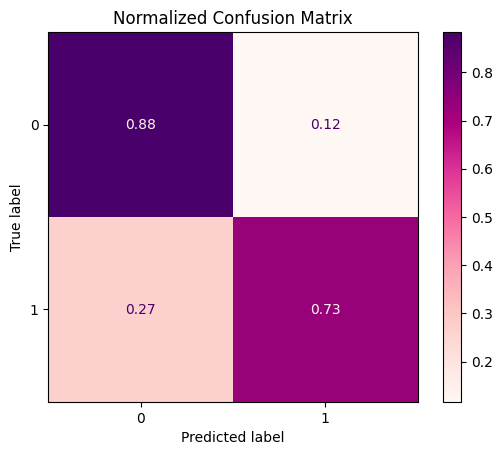

In [27]:
# to understand class-specific performance I normalise the confusion matrix
# which proportions of correct and incorrect predictions for each class,
# relative to the number of samples in that class
cm_normalized = confusion_matrix(y_test, y_pred, normalize="true")

print("[[TN, FP],\n [FN, TP]]")
print("Normalized Confusion Matrix:")
print(cm_normalized)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(cmap="RdPu")
plt.title("Normalized Confusion Matrix")
plt.show()

In the confusion matrix, the rows represent the ground truth, and the columns represent the predicted classes.

**Class 0**:

The model performs well at predicing negative samples, with a recall of 88%.
However, 12% of negative samples are incorrectly classified as positive.

**Class 1**:

The model is less effective at predicting positive samples, with a recall of 73%. --> there is room for improvement
as about 27% of positive samples are misclassified as negative.